<a href="https://colab.research.google.com/github/Alonso94/GSoC-DGP/blob/master/test_LVM_layers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
from mpl_toolkits.mplot3d import Axes3D
from tensorflow_probability import distributions as tfd
from tensorflow_probability import positive_semidefinite_kernels as tfk

%pylab inline
plt.rcParams['axes.facecolor']='white'
%config InlineBackend.figure_format="png"

Populating the interactive namespace from numpy and matplotlib


In [0]:
sess=tf.InteractiveSession()

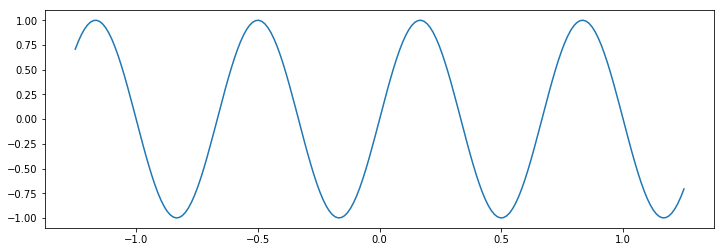

In [0]:
# test matplot
plt.figure(figsize=(12,4))
x=np.linspace(-1.25,1.25,200)
y= np.sin(3*np.pi*x)
plt.plot(x,y)
plt.show()

In [0]:
class Layer:
  # input size for the next layers will be equal to the latent variable size of the previous layer
  def __init__(input_size, output_size, limit=1.25,
               a_initial_val=1, ls_initial_val=1, obs_nv_initial_val=1, 
               learning_rate=0.1):
    # generate training variable of the layer
    # a - amplitude
    # ls - length scale
    # obs_nv - observation noise variance
    # these variables will be optimized during the training

    # finfo : Machine limits for floating point types
    # tiny : The smallest positive usable numbe
    # softplus: a smooth approximation of a rectifier 
    # rectifier(x) = max(0,x)
    # softplus(x) = log(1+exp(x))
    tiny=np.finfo(np.float64).tiny

    a_variable=tf.Variable(initial_value=a_initial_val,name="amplitude",dtype=np.float64)
    self.a=(tiny + tf.nn.softplus(a_variable))

    ls_variable=tf.Variable(initial_value=ls_initial_val,name="length_scale",dtype=np.float64)
    self.ls=(tiny + tf.nn.softplus(ls_variable))

    obs_nv_variable=tf.Variable(initial_value=obs_nv_initial_val,name="observation_noise_variance",dtype=np.float64)
    self.obs_nv=(tiny + tf.nn.softplus(obs_nv_variable))
    
    # use Exponentiated quadratic kernel
    # or could be called squared exponential, Gaussian, or radial basis function
    # k(x, y) = amplitude**2 * exp(-||x - y||**2 / (2 * length_scale**2))
    self.kernel = tfk.ExponentiatedQuadratic( self.a, self.ls )
    
    init=np.random.normal(size=(output_size,1))
    lat_ind_pts=tf.get_variable(name="latent_index_points",dtype=tf.float64,initializer=init)

    self.prior=tfd.GaussianProcess(kernel=kernel, index_points=lat_ind_pts, observation_noise_variance=obs_nv)
    
    
    # define the number of the inducing points
    self.num_inducing_points=20

    # we have to make trainable inducing points
    init_inducing=np.linspace(-limit,limit,num_inducing_points,dtype=np.float64)[...,newaxis]
    self.inducing_ind_pts=tf.Variable(init_inducing,dtype=np.float64,name='inducing_index_points')

    init_loc=np.zeros([num_inducing_points],dtype=np.float64)
    self.variational_ind_obs_loc=tf.Variable(init_loc,name="variational_inducing_observations_loc")

    init_scale=np.eye(num_inducing_points,dtype=np.float64)
    self.variational_ind_obs_scale=tf.Variable(init_scale,name="variational_inducing_observations_scale")
    
    # index_points locations over which we will construct the approximate posterior
    self.num_predictive_ind_pts=500
    self.predictive_index_pts=np.linspace(-limit,limit,num_predictive_ind_pts,dtype=np.float64)[...,np.newaxis]

    self.input_placeholder = tf.placeholder(dtype, [input_size, 1], name='layer_input')

    # construct the VGP distribution
    self.variational_posterior=tfd.VariationalGaussianProcess(kernel=kernel, 
                                                              index_points=self.input_placeholder,
                                                              inducing_index_points=self.inducing_ind_pts,
                                                              variational_inducing_observations_loc=self.variational_ind_obs_loc,
                                                              variational_inducing_observations_scale=self.variational_ind_obs_scale)
    
    
    # compute the lower bound terms
    def loss(self, X, Y):
      
      # Compute the logprob from the posterior evaluated at latent_sample
      ################################################
      ##
      ##   (Equation 17 - Doubly stochastic DGP paper)
      ##
      ################################################
      self.variational_posterior=sess.run(self.variational_posterior,feed_dict={self.input_placeholder: X})
      
      all_log_probs = self.variational_posterior.log_prob(Y)
      

      # Reduce sum over the data dimensions
      likelihood_term = tf.reduce_sum(all_log_probs, axis=1)

      # Reduce mean over the batch dimensions
      likelihood_term = tf.reduce_mean(likelihood_term)

      # Compute the KL divergence term
      kl_term = self.variational_posterior.kl_divergence(self.prior)

      # Reduce over the dimension.
      kl_term = tf.reduce_mean(kl_term)
      
      loss = likelihood_term + kl_term

      return loss
    
  def loss_and_optimize(self,DGP_accumulated_loss,X, Y):
    
    DGP_accumulated_loss += self.loss(X, Y)
    
    optimizer = tf.train.AdamOptimizer()
    train_op = optimizer.minimize(DGP_accumulated_loss)
    
    return DGP_accumulated_loss
  
  def update_prior(self):
    self.prior= self.variational_posterior
    
  def __Call__(self, X):
      self.variational_posterior=sess.run(self.variational_posterior,feed_dict={input_placeholder: X})
      sample= self.variational_posterior.sample()
      return sess.run(sample)
     

In [0]:
class DGP:
  def __init__(self, input_size, output_size, num_hidden_layers=0, latent_size=20):
    
    self.input_placeholder = tf.placeholder(dtype, [input_size, 1], name='DGP_input')
    self.output_placeholder = tf.placeholder(dtype, [input_size, 1], name='DGP_input')
    
    self.input_size=input_size
    self.output_size=output_size
    self.num_hidden_layers=num_hidden_layers
    self.latent_size=latent_size
    
    build_model()
    
    layers=[]
    
    self.loss=0
    
  def build_model(self):
    
    layers.append(layer(self.input_Size,self.latent_size))
    for i in range(self.num_hidden_layers):
      layer.append(layer(self.latent_size,self.latent_size))
    layers.append(layer(self.latent_Size,self.))
    
  def build_graph(self):
    x= self.input_placeholder
    for i in range(len(layers)):
      x=layers[i](x)
    self.output_placeholder=x
    
  def optimize(self):
    x= self.input_placeholder
    for i in range(len(layers)):
      x=layers[i](x)
      self.loss=layers[i].loss_and_optimize(self.loss,x,self.ouput_placeholder)
   
  def propagate(x):
    for i in range(2,len(layers)):
      ################################################
      ##
      ##   (Equation 15 - Doubly stochastic DGP paper)
      ##
      ################################################
      posterior=sess.run(layers[i-1].variational_posterior)
      # Draw a sample from the variational posterior
      latent_sample = posterior.sample()
      first_term=latent_sample.mean()
      
      cov=np.eye(layer_order,dtype=np.float64)
      e=np.random.normal(0,cov)
      # TODO check sampe's variance in variational GP class
      second_term= np.dot(e,np.sqrt(latent_sample.variance()))
      
      layer_pred=first_term + second_term
    return layer_pred
    